DATA PREPARATION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import joblib

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PhishingDetection/phishing_site_urls.csv')

In [ ]:
pip install python-whois


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 4.1 MB/s eta 0:00:00


In [ ]:
!pip install tldextract idna cryptography whois python-whois numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 3.4 MB/s eta 0:00:00


DATA PREPROCESSING

In [ ]:
import re
import numpy as np
from urllib.parse import urlparse, parse_qs
import ssl
import socket
from datetime import datetime
import whois
from cryptography import x509
from cryptography.hazmat.backends import default_backend
import tldextract
import idna

from datetime import datetime, timezone

def check_ssl_cert(url):
    try:
        parsed_url = urlparse(url)
        host = parsed_url.hostname
        port = 443
        context = ssl.create_default_context()

        with socket.create_connection((host, port), timeout=5) as sock:
            with context.wrap_socket(sock, server_hostname=host) as ssock:
                cert_der = ssock.getpeercert(binary_form=True)
                cert = x509.load_der_x509_certificate(cert_der, default_backend())

                ssl_valid = 1
                ssl_self_signed = 1 if cert.issuer == cert.subject else 0

                now = datetime.now(timezone.utc)
                validity = cert.not_valid_after_utc - datetime.now(timezone.utc)
                ssl_days_left = validity.days if validity.days > 0 else 0

                return ssl_valid, ssl_self_signed, ssl_days_left
    except Exception as e:
        return 0, 0, 0

def get_whois_features(domain):
    features = {
        'domain_age_days': -1,
        'domain_expiry_days': -1,
        'domain_registered': 0,
        'domain_country': '',
        'has_whois_info': 0,
        'registrar': '',
        'name_servers_count': 0
    }

    try:
        info = whois.whois(domain)
        features['has_whois_info'] = 1

        # Handle dates
        creation_date = info.creation_date
        expiration_date = info.expiration_date

        if isinstance(creation_date, list):
            creation_date = creation_date[0]
        if isinstance(expiration_date, list):
            expiration_date = expiration_date[0]

        if creation_date and isinstance(creation_date, datetime):
            features['domain_age_days'] = (datetime.utcnow() - creation_date).days
        if expiration_date and isinstance(expiration_date, datetime):
            features['domain_expiry_days'] = (expiration_date - datetime.utcnow()).days

        # Additional WHOIS features
        features['domain_registered'] = 1 if creation_date else 0
        features['registrar'] = info.registrar if info.registrar else ''
        features['name_servers_count'] = len(info.name_servers) if info.name_servers else 0
        features['domain_country'] = info.country if info.country else ''

    except Exception:
        pass

    return features

def get_tld_features(domain):
    extracted = tldextract.extract(domain)
    return {
        'subdomain_count': len(extracted.subdomain.split('.')),
        'tld': extracted.suffix,
        'domain_part_count': len(extracted.subdomain.split('.')) + 2  # subdomain + domain + suffix
    }

def is_shortener(url):
    shorteners = {'bit.ly', 'goo.gl', 'tinyurl.com', 'ow.ly', 't.co', 'is.gd'}
    return 1 if any(s in url for s in shorteners) else 0

def entropy(s):
    p, lns = np.unique(list(s), return_counts=True)
    return -np.sum((lns/lns.sum()) * np.log2(lns/lns.sum()))

def extract_features(URL):
    features = {}

    # Basic URL features
    features['URL_length'] = len(URL)
    features['num_dots'] = URL.count('.')
    features['num_hyphens'] = URL.count('-')
    features['num_slashes'] = URL.count('/')
    features['num_question_marks'] = URL.count('?')
    features['num_equals'] = URL.count('=')
    features['num_at'] = URL.count('@')
    features['has_ip'] = 1 if re.match(r"^(https?:\/\/)?(\d{1,3}\.){3}\d{1,3}", URL) else 0

    # Parsed components
    parsed = urlparse(URL)
    domain = parsed.netloc
    path = parsed.path
    query = parsed.query

    # Domain analysis
    features['domain_length'] = len(domain)
    tld_features = get_tld_features(domain)
    features.update(tld_features)
    features['is_idn'] = 1 if 'xn--' in domain else 0  # Internationalized domain name

    # Path analysis
    features['path_length'] = len(path)
    features['path_depth'] = path.count('/')
    features['file_extension'] = 1 if '.' in path.split('/')[-1] else 0

    # Query parameters analysis
    params = parse_qs(query)
    features['num_parameters'] = len(params)
    sensitive_params = {'password', 'login', 'user', 'creditcard'}
    features['sensitive_params'] = sum(1 for p in params if p.lower() in sensitive_params)

    # Security features
    features['uses_https'] = 1 if parsed.scheme == 'https' else 0
    ssl_valid, ssl_self_signed, ssl_days_left = check_ssl_cert(URL)
    features.update({
        'ssl_cert_valid': ssl_valid,
        'ssl_self_signed': ssl_self_signed,
        'ssl_days_left': ssl_days_left
    })

    # Content features
    features['entropy'] = entropy(URL)
    features['is_shortened'] = is_shortener(URL)
    suspicious_keywords = ['login', 'verify', 'secure', 'account', 'update',
                         'bank', 'paypal', 'signin', 'confirm', 'password']
    features['suspicious_keywords'] = sum(1 for word in suspicious_keywords if word in URL.lower())

    # WHOIS features
    whois_data = get_whois_features(domain)
    features.update(whois_data)

    # Additional features
    features['non_standard_port'] = 1 if parsed.port not in [None, 80, 443] else 0
    features['hex_chars'] = len(re.findall(r'%[0-9a-fA-F]{2}', URL))
    features['redirects'] = len(re.findall('//', URL)) - 1

    # IP and network features
    try:
        ip = socket.gethostbyname(domain)
        features['ip_private'] = 1 if ip.startswith(('10.', '172.', '192.168.')) else 0
    except:
        features['ip_private'] = 0

    return features

In [ ]:
url = "https://chatgpt.com/c/6831d57a-b888-800e-954f-bbb35764fb63"
features = extract_features(url)
for key, value in features.items():
    print(f"{key}: {value}")


URL_length: 58
num_dots: 1
num_hyphens: 4
num_slashes: 4
num_question_marks: 0
num_equals: 0
num_at: 0
has_ip: 0
domain_length: 11
subdomain_count: 1
tld: com
domain_part_count: 3
is_idn: 0
path_length: 39
path_depth: 2
file_extension: 0
num_parameters: 0
sensitive_params: 0
uses_https: 1
ssl_cert_valid: 1
ssl_self_signed: 0
ssl_days_left: 83
entropy: 4.474552875170202
is_shortened: 1
suspicious_keywords: 0
domain_age_days: -1
domain_expiry_days: -1
domain_registered: 0
domain_country: 
has_whois_info: 0
registrar: 
name_servers_count: 0
non_standard_port: 0
hex_chars: 0
redirects: 0
ip_private: 1


In [ ]:
print(df.head())
print(df.columns)


                                                 URL Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad
3  mail.printakid.com/www.online.americanexpress....   bad
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad
Index(['URL', 'Label'], dtype='object')


In [ ]:

# Feature Extraction with Validation
def safe_extract_features(url):
    try:
        return extract_features(url)
    except Exception as e:
        print(f"Error processing {url}: {str(e)}")
        return None


feature_data = df['URL'].apply(safe_extract_features)

# Convert to DataFrame with filtering
X = pd.DataFrame([fd for fd in feature_data if fd is not None])

# Handle missing values properly
X = X.fillna({
    'ssl_days_left': -1,
    'domain_age_days': -1,
    'domain_expiry_days': -1,
    'domain_country': 'unknown',
    'registrar': 'unknown'
}).fillna(0)

# Convert categorical features using one-hot encoding
categorical_cols = ['domain_country', 'tld', 'registrar']
X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols)

# Ensure numeric types and final cleaning
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Align labels with cleaned features
valid_indices = X.index
y = df.iloc[valid_indices]['Label'].reset_index(drop=True)
X = X.reset_index(drop=True)

# Final Validation
assert len(X) == len(y), "Feature/Label length mismatch after cleaning!"
assert X.isna().sum().sum() == 0, "Missing values remaining in features!"
assert (X.dtypes != 'object').all(), "Non-numeric features remaining!"

print(f"Final feature matrix shape: {X.shape}")
print(f"Label distribution:\n{y.value_counts()}")

Final feature matrix shape: (549346, 56)
Label distribution:
Label
good    392924
bad     156422
Name: count, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, )

In [ ]:

feature_names = X_train.columns.to_list()

import joblib
joblib.dump(feature_names, "feature_names.pkl")



['feature_names.pkl']

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
corr_matrix = pd.DataFrame(X_train, columns=X.columns).corr()

In [ ]:
print(corr_matrix)


                     URL_length  num_dots  num_hyphens  num_slashes  \
URL_length             1.000000  0.491514     0.419772     0.385312   
num_dots               0.491514  1.000000    -0.024422     0.194533   
num_hyphens            0.419772 -0.024422     1.000000     0.216003   
num_slashes            0.385312  0.194533     0.216003     1.000000   
num_question_marks     0.307063  0.247617    -0.038057     0.067328   
num_equals             0.540902  0.324738     0.004774     0.056687   
num_at                 0.078991  0.095675    -0.009861     0.044339   
has_ip                -0.059783  0.114499    -0.054313    -0.077156   
domain_length          0.030401  0.034987     0.001206     0.033252   
subdomain_count        0.009057  0.017793     0.003649     0.008178   
domain_part_count      0.009057  0.017793     0.003649     0.008178   
is_idn                      NaN       NaN          NaN          NaN   
path_length            0.623606  0.356457     0.571503     0.520192   
path_d

MODEL


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Converts ['bad', 'good'] → [0, 1]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [ ]:

from sklearn.model_selection import cross_val_score

# 4. Model training with cross-validation

rf = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
rf.fit(X_train, y_train)

# 5. Evaluation
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.69      0.73     31200
           1       0.88      0.92      0.90     78670

    accuracy                           0.86    109870
   macro avg       0.83      0.81      0.82    109870
weighted avg       0.85      0.86      0.85    109870



In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score

# 1. XGBoost Implementation
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=2.5,
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.97      0.37      0.54     31200
           1       0.80      1.00      0.89     78670

    accuracy                           0.82    109870
   macro avg       0.88      0.68      0.71    109870
weighted avg       0.85      0.82      0.79    109870

ROC-AUC: 0.8682119668576624


In [ ]:
# 2. Logistic Regression Implementation
logreg = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    C=0.1,
    solver='liblinear',
    random_state=42
)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred_logreg))
print("ROC-AUC:", roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]))


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.55      0.53      0.54     31200
           1       0.82      0.83      0.82     78670

    accuracy                           0.74    109870
   macro avg       0.68      0.68      0.68    109870
weighted avg       0.74      0.74      0.74    109870

ROC-AUC: 0.7617272455045908


In [ ]:

# 3. Ensemble Model (Voting Classifier)
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
        ('logreg', logreg)
    ],
    voting='soft',  # Use probability for weighted voting
    n_jobs=-1
)
ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)
print("\nEnsemble Model Performance:")
print(classification_report(y_test, y_pred_ensemble))
print("ROC-AUC:", roc_auc_score(y_test, ensemble.predict_proba(X_test)[:, 1]))


Ensemble Model Performance:
              precision    recall  f1-score   support

           0       0.91      0.51      0.66     31200
           1       0.84      0.98      0.90     78670

    accuracy                           0.85    109870
   macro avg       0.87      0.75      0.78    109870
weighted avg       0.86      0.85      0.83    109870

ROC-AUC: 0.9055244851913054


In [ ]:
# 4. Feature Importance Analysis
import matplotlib.pyplot as plt


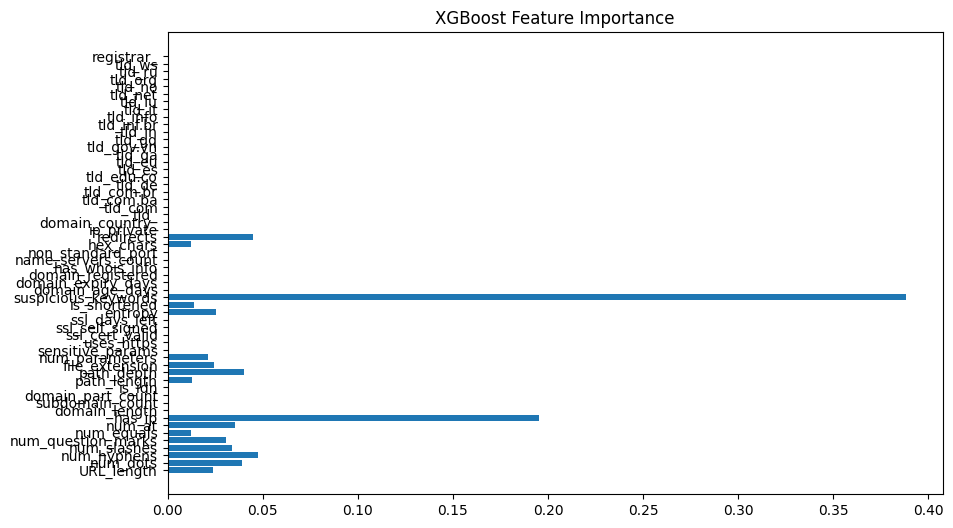

In [ ]:
# XGBoost Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns, xgb.feature_importances_)
plt.title('XGBoost Feature Importance')
plt.show()

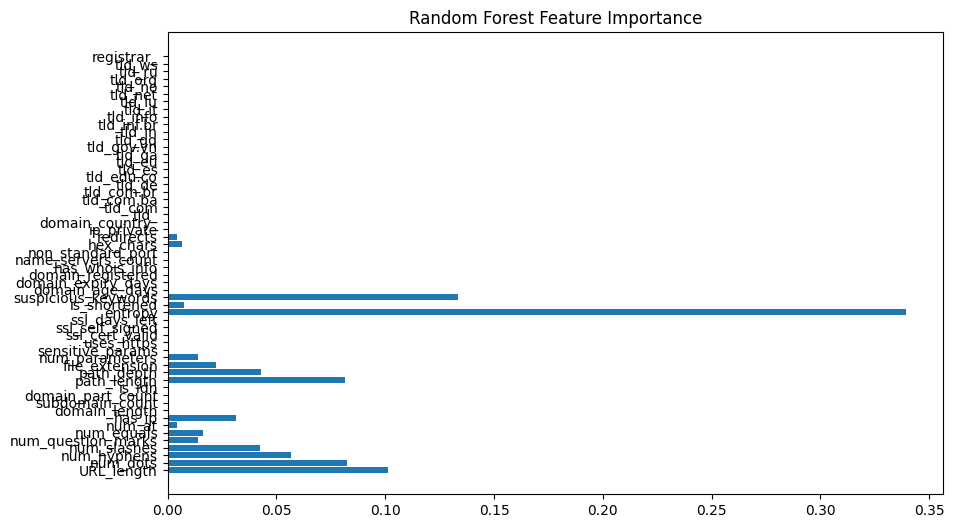

In [ ]:

# Random Forest Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns, rf.feature_importances_)
plt.title('Random Forest Feature Importance')
plt.show()

ENSEMBLE PIPELINE


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score

# 1. Create and train the ensemble pipeline
def create_ensemble_pipeline(X_train, y_train):
    """
    Creates and trains a complete phishing detection pipeline
    """
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling
        ('ensemble', VotingClassifier(
            estimators=[
                ('rf', rf),  # pre-trained Random Forest
                ('xgb', xgb),  # pre-trained XGBoost
                ('logreg', logreg)  # pre-trained Logistic Regression
            ],
            voting='soft',
            n_jobs=-1
        ))
    ])

    # Train the pipeline
    pipeline.fit(X_train, y_train)
    return pipeline

# 2. Create and save the pipeline
phishing_pipeline = create_ensemble_pipeline(X_train, y_train)
joblib.dump(phishing_pipeline, 'phishing_detection_pipeline.pkl')

['phishing_detection_pipeline.pkl']

In [ ]:
# 4. Feature importance analysis
def get_feature_importances(pipeline):
    """
    Extracts and combines feature importances from all models
    """
    importances = {}

    # Get Random Forest importances
    rf_importances = pipeline.named_steps['ensemble'].estimators_[0].feature_importances_
    importances['random_forest'] = rf_importances

    # Get XGBoost importances
    xgb_importances = pipeline.named_steps['ensemble'].estimators_[1].feature_importances_
    importances['xgboost'] = xgb_importances

    # Average importances
    avg_importances = np.mean([rf_importances, xgb_importances], axis=0)
    return pd.Series(avg_importances, index=X_train.columns).sort_values(ascending=False)

In [ ]:
# 3. Evaluation function
def evaluate_model(pipeline, X_test, y_test):
    """
    Evaluates pipeline performance and returns metrics
    """
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print("Model Evaluation:")
    print(classification_report(y_test, y_pred, target_names=['good', 'bad']))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print("\nFeature Importances:")
    print(get_feature_importances(pipeline))

In [ ]:
# 5. Prediction function
def predict_phishing(url, pipeline_path='phishing_detection_pipeline.pkl'):
    """
    End-to-end prediction function for new URLs
    """
    try:
        # Load pipeline
        pipeline = joblib.load(pipeline_path)

        # Extract features
        features = extract_features(url)

        # Convert to DataFrame
        input_data = pd.DataFrame([features])

        # Make prediction
        prob = pipeline.predict_proba(input_data)[0][1]

        return {
            'url': url,
            'phishing_probability': float(prob),
            'prediction': 'bad' if prob > 0.5 else 'good',
            'features_used': list(features.keys())
        }
    except Exception as e:
        return {'error': str(e), 'url': url}

In [ ]:
# 6. Evaluate the pipeline
print("Final Pipeline Evaluation:")
evaluate_model(phishing_pipeline, X_test, y_test)

Final Pipeline Evaluation:
Model Evaluation:
              precision    recall  f1-score   support

        good       0.91      0.51      0.66     31200
         bad       0.84      0.98      0.90     78670

    accuracy                           0.85    109870
   macro avg       0.87      0.75      0.78    109870
weighted avg       0.86      0.85      0.83    109870

ROC-AUC Score: 0.9055

Feature Importances:
suspicious_keywords    2.619034e-01
entropy                1.824738e-01
has_ip                 1.159705e-01
URL_length             6.218811e-02
num_dots               6.040363e-02
num_hyphens            5.201287e-02
path_length            4.683016e-02
path_depth             4.096032e-02
num_slashes            3.737880e-02
redirects              2.564583e-02
file_extension         2.368277e-02
num_question_marks     2.048837e-02
num_parameters         1.803115e-02
num_at                 1.802016e-02
num_equals             1.464716e-02
is_shortened           1.015686e-02
hex_char

In [ ]:
sample_url = "http://example.com/login.php?user=test&password=1234"
print("\nSample Prediction:")
print(predict_phishing(sample_url))


Sample Prediction:
{'error': 'The feature names should match those that were passed during fit.\nFeature names unseen at fit time:\n- domain_country\n- registrar\n- tld\nFeature names seen at fit time, yet now missing:\n- domain_country_\n- registrar_\n- tld_\n- tld_com\n- tld_com.ba\n- ...\n', 'url': 'http://example.com/login.php?user=test&password=1234'}


In [ ]:
print(pipeline)


Pipeline(steps=[('scaler', StandardScaler()),
                ('ensemble',
                 VotingClassifier(estimators=[('rf',
                                               RandomForestClassifier(random_state=42)),
                                              ('xgb',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=0.8,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=Fals

In [ ]:
print(pipeline.named_steps)


{'scaler': StandardScaler(), 'ensemble': VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type...
                                            max_cat_to_onehot=None,
                      

In [ ]:
model = pipeline if not hasattr(pipeline, 'named_steps') else pipeline.named_steps[list(pipeline.named_steps)[-1]]

if hasattr(model, 'feature_names_in_'):
    feature_names = model.feature_names_in_
    print("Expected features:", list(feature_names))
else:
    print("Model does not expose feature names.")


Model does not expose feature names.


In [ ]:
import pandas as pd

def predict_phishing(url):
    features = extract_features(url)
    filtered_features = {key: features.get(key, 0) for key in expected_features}
    input_df = pd.DataFrame([filtered_features])
    prediction = model.predict(input_df)[0]
    return "Phishing" if prediction == 1 else "Legitimate"


SAMPLE PREDICTIONS


In [ ]:
import joblib
import pandas as pd

model = joblib.load("phishing_detection_pipeline.pkl")
feature_names = joblib.load("feature_names.pkl")

def predict_phishing(url):
    features = extract_features(url)

    filtered_features = {key: features.get(key, 0) for key in feature_names}

    input_df = pd.DataFrame([filtered_features], columns=feature_names)

    prediction = model.predict(input_df)[0]
    return "Phishing" if prediction == 1 else "Legitimate"

sample_url = "http://example.com/login.php?user=test&password=1234"
print(predict_phishing(sample_url))


Legitimate


In [ ]:
sample_url = "xini.eu/00Qe"
print(predict_phishing(sample_url))



Phishing


In [ ]:
sample_url = "https://chatgpt.com/c/6831ea00-24c8-800e-91ff-08bcedead074"
print(predict_phishing(sample_url))

Legitimate


In [ ]:
print(feature_names)

['URL_length', 'num_dots', 'num_hyphens', 'num_slashes', 'num_question_marks', 'num_equals', 'num_at', 'has_ip', 'domain_length', 'subdomain_count', 'domain_part_count', 'is_idn', 'path_length', 'path_depth', 'file_extension', 'num_parameters', 'sensitive_params', 'uses_https', 'ssl_cert_valid', 'ssl_self_signed', 'ssl_days_left', 'entropy', 'is_shortened', 'suspicious_keywords', 'domain_age_days', 'domain_expiry_days', 'domain_registered', 'has_whois_info', 'name_servers_count', 'non_standard_port', 'hex_chars', 'redirects', 'ip_private', 'domain_country_', 'tld_', 'tld_com', 'tld_com.ba', 'tld_com.br', 'tld_de', 'tld_edu.co', 'tld_es', 'tld_eu', 'tld_ga', 'tld_gov.vn', 'tld_gq', 'tld_in', 'tld_inf.br', 'tld_info', 'tld_it', 'tld_lu', 'tld_net', 'tld_no', 'tld_org', 'tld_ru', 'tld_ws', 'registrar_']


In [ ]:
sample_url = "phlebolog.com.ua/libraries/joomla/results.php"
print(predict_phishing(sample_url))

Phishing


In [ ]:
sample_url = "nextgensmartphones.com//indexer/Trulia/index.htm"
print(predict_phishing(sample_url))

Legitimate


In [ ]:
from sklearn.metrics import accuracy_score

y_train_pred = model.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))


Training Accuracy: 0.8701499057969035
